In [1]:
import glob
import tensorflow as tf

In [2]:
images_folder = '../images'

Shape of the image: (1428, 1882, 3)


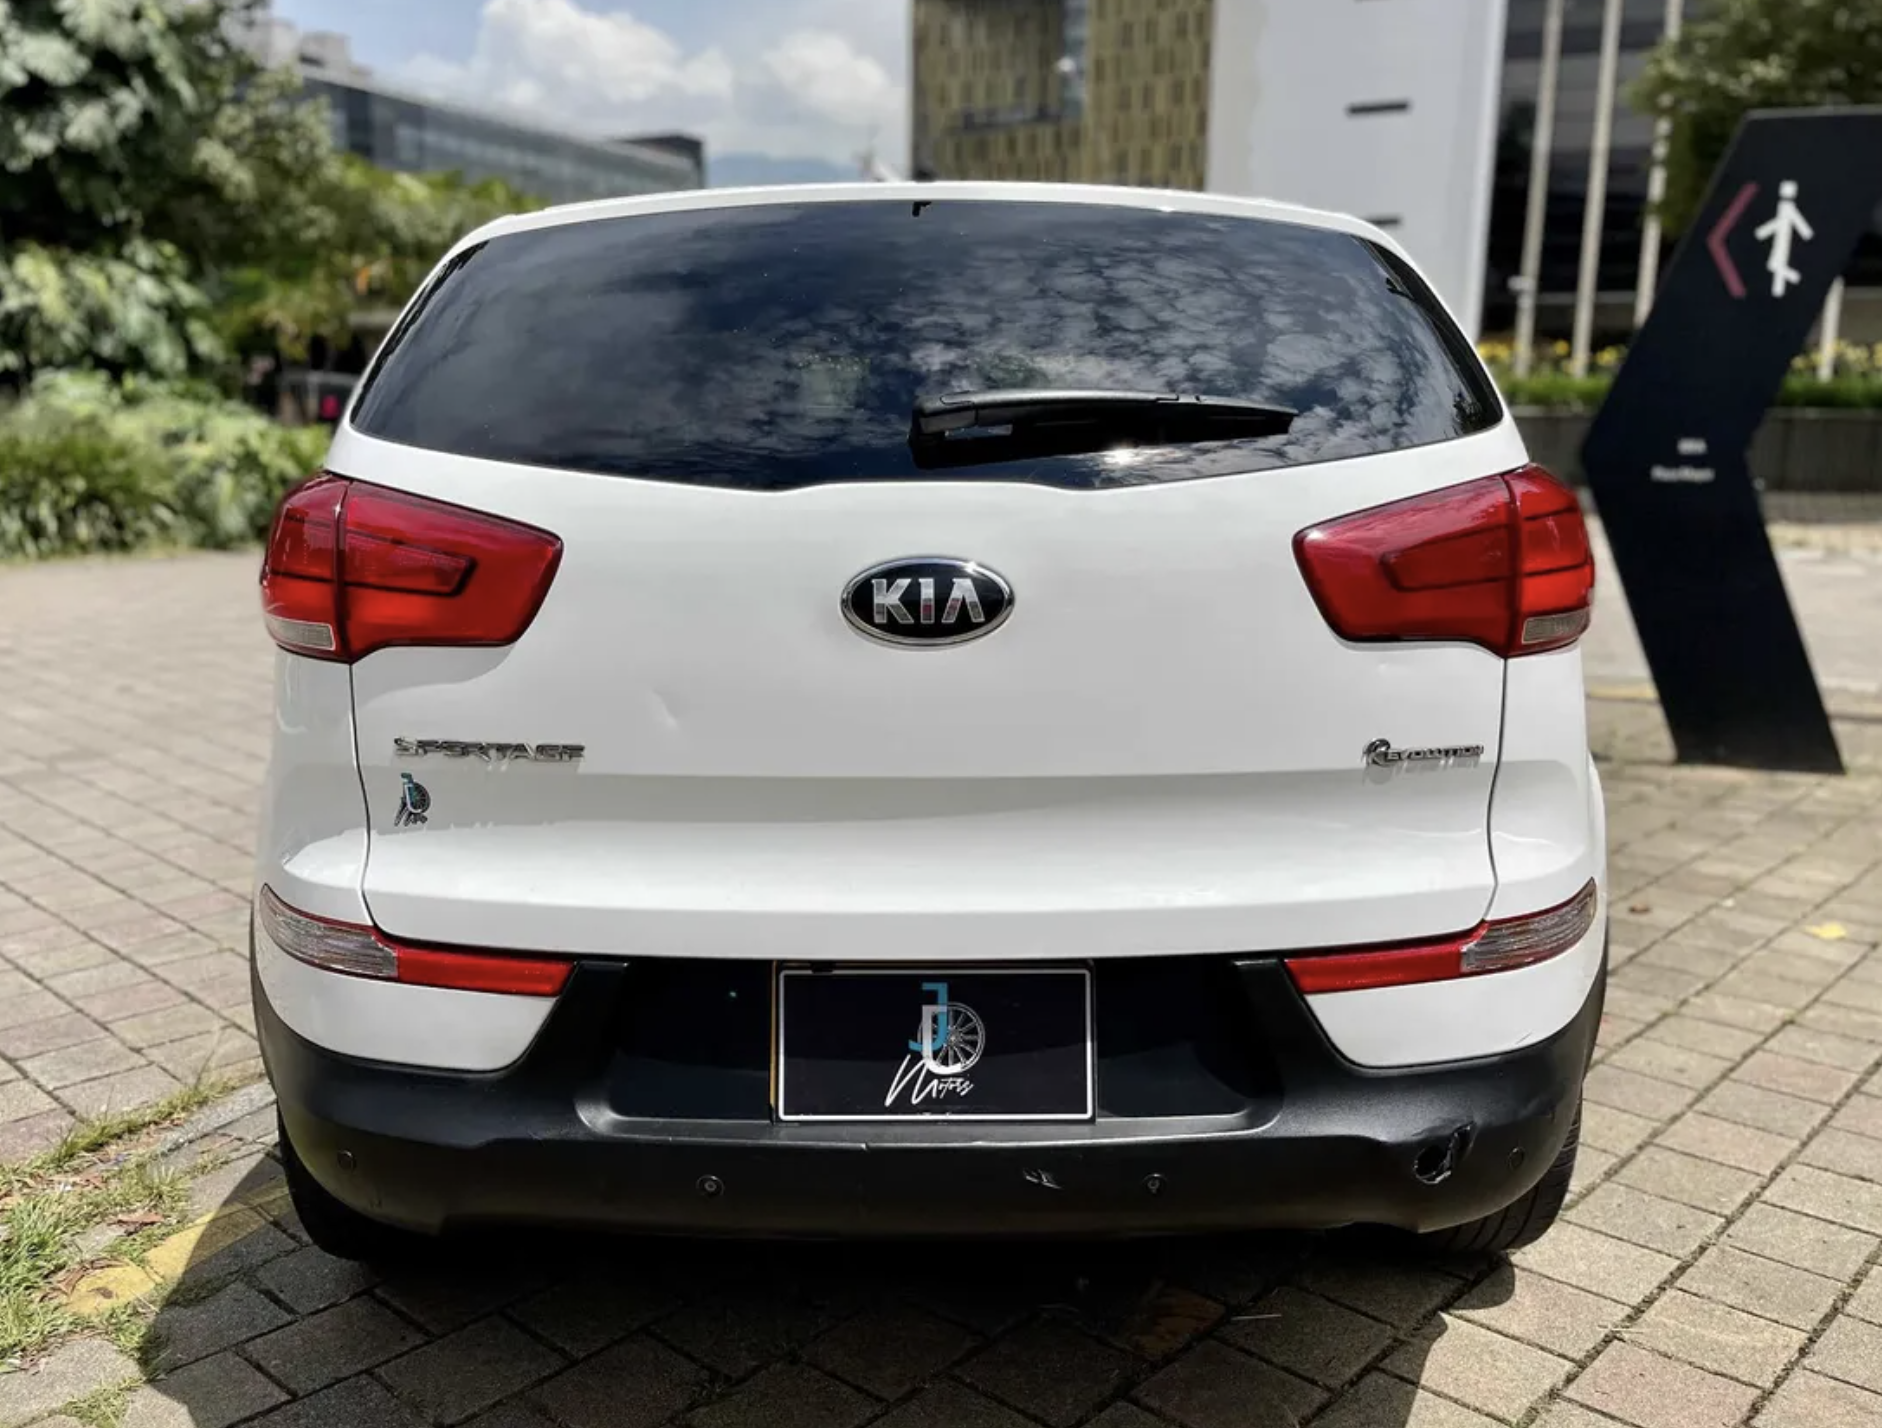

In [3]:
# test load image
image_files = glob.glob(images_folder + '/*/*.png')
image = image_files[0]

pil_image = tf.keras.preprocessing.image.load_img(image)
tf_image = tf.keras.preprocessing.image.img_to_array(pil_image)
print(f'Shape of the image: {tf_image.shape}')
pil_image

The image has a big resolution (1920 x 1458 x 3) which needs to be reduced for computational purposes.

In [12]:
# callback
class AccReached(tf.keras.callbacks.Callback):
  def __init__(self):
    pass
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True


In [62]:
# import images
train_images = tf.keras.preprocessing.image_dataset_from_directory(
  images_folder,
  labels='inferred',
  image_size=(256, 256),
  batch_size=8,
  shuffle=True,
  validation_split=0.2,
  subset='training',
  seed=42,
)
validation_images = tf.keras.preprocessing.image_dataset_from_directory(
  images_folder,
  labels='inferred',
  image_size=(256, 256),
  batch_size=8,
  shuffle=False,
  validation_split=0.2,
  subset='validation',
  seed=42,
)
labels = train_images.class_names
train_images = train_images.map(lambda x, y: (x / 255.0, y))
validation_images = validation_images.map(lambda x, y: (x / 255.0, y))

Found 917 files belonging to 3 classes.
Using 734 files for training.
Found 917 files belonging to 3 classes.
Using 183 files for validation.


In [54]:
model = tf.keras.models.Sequential([
    # tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(256, 256, 3)),
    # tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [55]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=0.001),
  metrics=['accuracy'],
)

In [56]:
history = model.fit(
  train_images.repeat(),
  steps_per_epoch=115,
  epochs=50,
  verbose=1,
  callbacks=[AccReached()],
  validation_data=validation_images,
)

Epoch 1/50


2022-11-02 15:23:12.999995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - ETA: 0s - loss: 0.7472 - accuracy: 0.7298

2022-11-02 15:23:24.265913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 14s 102ms/step - loss: 0.7472 - accuracy: 0.7298 - val_loss: 0.5631 - val_accuracy: 0.8634
Epoch 2/50
115/115 [==============================] - 12s 102ms/step - loss: 0.6358 - accuracy: 0.7647 - val_loss: 0.2711 - val_accuracy: 0.9836
Epoch 3/50
115/115 [==============================] - 13s 109ms/step - loss: 0.5869 - accuracy: 0.7734 - val_loss: 0.4601 - val_accuracy: 0.8962
Epoch 4/50
115/115 [==============================] - 10s 91ms/step - loss: 0.5392 - accuracy: 0.7915 - val_loss: 0.2927 - val_accuracy: 0.9344
Epoch 5/50
115/115 [==============================] - 13s 107ms/step - loss: 0.5117 - accuracy: 0.8224 - val_loss: 0.1442 - val_accuracy: 0.9891
Epoch 6/50
115/115 [==============================] - 11s 98ms/step - loss: 0.4717 - accuracy: 0.8355 - val_loss: 0.3824 - val_accuracy: 0.8852
Epoch 7/50
115/115 [==============================] - 11s 97ms/step - loss: 0.4691 - accuracy: 0.8279 - val_loss: 0.1116 - val_accuracy: 1.0000

1/1 [==============================] - 0s 82ms/step
Model prediction: back


2022-11-02 15:30:37.211814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


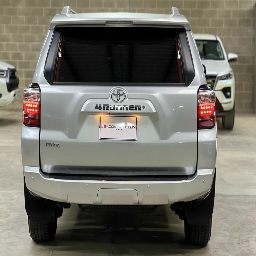

In [57]:
# prediction
new_image = image_files[50]
pil_image = tf.keras.preprocessing.image.load_img(new_image, target_size=(256, 256))
tf_image = tf.keras.preprocessing.image.img_to_array(pil_image)
probs = model.predict(tf_image.reshape(1, 256, 256, 3))
print(f'Model prediction: {labels[probs.argmax()]}')
pil_image

In [58]:
# save the model
model.save('labeling_model.h5')

In [60]:
labels

['back', 'front', 'other']